In [15]:
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.decomposition import PCA
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [3]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cuda


In [4]:
## Data Acquisition
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

In [5]:
def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

In [6]:
def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"
ratings = get_ratings_from_csv()
print(ratings)
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)
# films = get_data_from_csv(f"{root}/{ratings}")[]

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5
25000092  162541    56176     2.0
25000093  162541    58559     4.0
25000094  162541    63876     5.0

[25000095 rows x 3 columns]
Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 colum

In [7]:
# DATA VISUALIZATION

            # # Fill in missing values with zeros
            # X.fillna(0, inplace=True)

# FARE TEST CON AVG, STD_DEV
def addColumnOperation(ratings,X):
     # Compute the mean rating for each user
     count_rating = ratings.groupby('movieId', as_index=False)['rating'].count()
     std= ratings.groupby('movieId', as_index=False)['rating'].std()
     std.fillna(0, inplace=True)
     min_ratings= ratings.groupby('movieId', as_index=False)['rating'].min()
     max_ratings= ratings.groupby('movieId', as_index=False)['rating'].max()
     median= ratings.groupby('movieId', as_index=False)['rating'].median()
     operation = pd.DataFrame({'movieId':count_rating['movieId'],'count_rating': count_rating['rating'], 'std': std['rating'], 'min': min_ratings['rating'], 'max': max_ratings['rating'], 'median': median['rating']}) 
     X = pd.merge(X, operation, on='movieId')
     X.drop("movieId", axis=1, inplace=True)
     return X

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
           

class TabNet:
    def __init__(self, ratings, relevance, seed=42,width_values = 8, steps = 3, learning_rate = 2e-2):
        self.aug = RegressionSMOTE(p=0.2)
        #! df['rating'] = df['rating'].astype('float16')

        # Reduce genome-score size


        self.train_loss_history = []
        self.val_loss_history = []

        # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        ratings = None  
        train = X
        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state = seed).reset_index(drop=True)
        
        if "Set" not in train.columns:
            train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

        features = [ col for col in train.columns if col not in ["rating", "Set"]]
        target = "rating"
        
        train_indices = train[train.Set=="train"].index
        valid_indices = train[train.Set=="valid"].index
        test_indices = train[train.Set=="test"].index

        self.X_train = train[features].values[train_indices]
        self.y_train = train[target].values[train_indices].reshape(-1, 1)

        self.X_valid = train[features].values[valid_indices]
        self.y_valid = train[target].values[valid_indices].reshape(-1, 1)

        self.X_test = train[features].values[test_indices]
        self.y_test = train[target].values[test_indices].reshape(-1, 1)

        pca = PCA()
        pca.fit(self.X_train)
        self.X_train = pca.transform(self.X_train)
        self.X_test = pca.transform(self.X_test)
        self.X_valid = pca.transform(self.X_valid)
        
        if torch.cuda.is_available():
            self.model = TabNetRegressor(n_d = width_values, n_a = width_values , n_steps = steps, optimizer_params = dict(lr=learning_rate), seed=seed, device_name="cuda")  
        else:
            self.model = TabNetRegressor(n_d = width_values, n_a = width_values , n_steps = steps, optimizer_params = dict(lr=learning_rate), seed=seed)  



    def train(self,max_epochs = 150,batchsize = 1024):
        self.model.fit(
            X_train=self.X_train, y_train=self.y_train,
            eval_set=[(self.X_train,self.y_train), (self.X_valid, self.y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
            max_epochs=max_epochs,
            patience=20,
            batch_size=batchsize, virtual_batch_size=1024,
            num_workers=0,
            drop_last=False,
            augmentations=self.aug, #aug
        ) 

        return self.model.history

    def test(self):
        # Predict the labels of the test set: y_pred
        y_pred = self.model.predict(self.X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        print("=====================================")
        return r2,self.model
    
    def load(self,model):
        self.model =TabNetRegressor()
        self.model.load_model(model)
    
    def save(self,root,name):
        self.model.save_model(f"{root}/{name}.pt")


In [12]:
model = TabNet(ratings, genome_scores)

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [14]:
import itertools

history = None

batchsize = [512]
width = [32]
steps = [5]
learning_rate = [2e-2]
max_epochs = [150]

best_model_params = None 
best_r2 = 0

total_iterations = len(batchsize) * len(width) * len(steps) * len(learning_rate) * len(max_epochs)
current_iteration = 0

for batchsize,width,steps,learning_rate,max_epochs in itertools.product(batchsize,width,steps,learning_rate,max_epochs):
    current_iteration += 1
    print(f"[{current_iteration}/{total_iterations}] START => batchsize: {batchsize} width: {width} steps: {steps} learning_rate: {learning_rate} max_epochs: {max_epochs}")
    model = TabNet(ratings, genome_scores,width_values = width, steps = steps, learning_rate = learning_rate)
    history = model.train(max_epochs = max_epochs,batchsize = batchsize)
    r2score, instance = model.test()
    if r2score > best_r2:
        best_r2 = r2score
        best_model_params = f'{batchsize}_{width}_{steps}_{learning_rate}_{max_epochs}'
        model.save("model",best_model_params)
        print(f"New best model: {best_model_params} with r2: {best_r2}")

# model = TabNetRegressor(ratings,genome_scores)
# print(f'Best model SCORE: {best_r2}')
# model.load(f"model/{best_model_params}.pt.zip")
# print(model.test())



[1/1] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.49595 | train_rmsle: 0.25339 | train_mae: 1.66944 | train_rmse: 1.73779 | train_mse: 3.01992 | valid_rmsle: 0.25516 | valid_mae: 1.67669 | valid_rmse: 1.74425 | valid_mse: 3.04241 |  0:00:01s
epoch 1  | loss: 0.68901 | train_rmsle: 0.12799 | train_mae: 1.25026 | train_rmse: 1.33312 | train_mse: 1.7772  | valid_rmsle: 0.12859 | valid_mae: 1.25369 | valid_rmse: 1.33734 | valid_mse: 1.78847 |  0:00:02s
epoch 2  | loss: 0.36487 | train_rmsle: 0.10927 | train_mae: 1.16508 | train_rmse: 1.25029 | train_mse: 1.56324 | valid_rmsle: 0.10985 | valid_mae: 1.1683  | valid_rmse: 1.25477 | valid_mse: 1.57445 |  0:00:04s
epoch 3  | loss: 0.31525 | train_rmsle: 0.08541 | train_mae: 1.04073 | train_rmse: 1.1293  | train_mse: 1.27531 | valid_rmsle: 0.08568 | valid_mae: 1.04268 | valid_rmse: 1.13258 | valid_mse: 1.28273 |  0:00:05s
epoch 4  | loss: 0.28473 | train_rmsle: 0.03898 | train_mae: 0.71155 | train_rmse: 0.80416 | train_mse: 0.64667 | valid_rmsle: 0.0389  | valid_mae: 0.71111 

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00813222251691739 RMSE: 0.09017883630274562 R2: 0.9640017844139963 MAE: 0.06946582838404507
Successfully saved model at model/512_32_5_0.02_150.pt.zip
New best model: 512_32_5_0.02_150 with r2: 0.9640017844139963


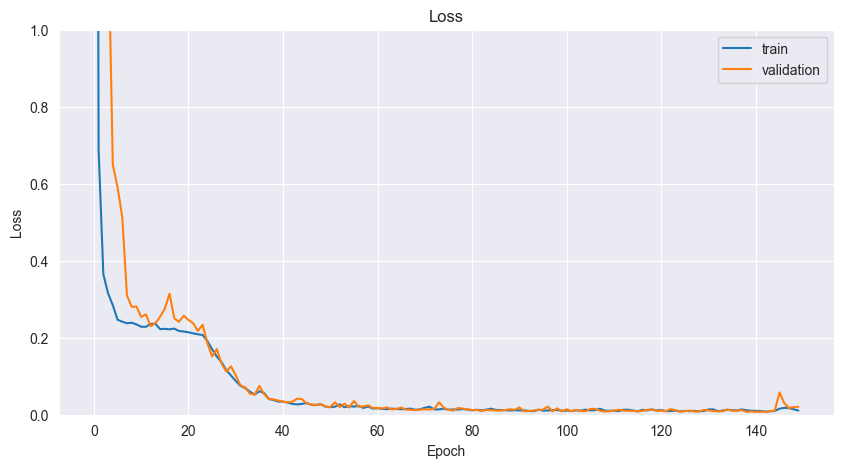

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='train')
plt.plot(history['valid_mse'],label='validation')
plt.ylim(0,1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()